Please note that I used part of the code provied in the lecture notes and in the TA session
In my code I also included check points = commented chunks that can be uncomented to understand better what my variable mean

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import os
import math
import seaborn as sns
import scipy

In [2]:
X = np.array([ 11.50, -2.32, 9.18]) # n=3 observations
true_sigma = 60. # Student also tells you this in beginner's game
true_mu = -20. # the unknown column position, mu
gridrows = np.linspace( 100.0,   5.0, 20)   # rows i of the grid are sigma, std. dev
gridcols = np.linspace(-100.,  100.0, 21)   # columns j of the grid are mu, mean (location)#gridcols #this is all the possibles values of mu
ncols    = len(gridcols)
nrows    = len(gridrows)

# 1. the beginner’s game
Write a script that:
takes observations and one of the 20 possible values of (i.e. a known row, specified by Student)
as input.
calculates the posterior probability for each of the 21 possible values of on that grid row.
Remember that the prior is uniform.
plots that distribution on a semilog scale (so you can see differences in the small-probability tail more
easily), using the semilogy plot of matplotlib for example.
and plots the pub’s calculated probability distribution on the same semilog plot, so you can compare.

This is the process I use to find the probablitiies for this part-
the goal is to find, for each one of the 21 discrete values that mu can take :

- P(mu|X,sigma) 

with X being the 3 observations(data points) and sigma =60 (for the first part) 


to what is that equal to?
Given Bayes Theorem we can say that 

P(mu chosen |X,sigma) = (p(X|mu chosen,sigma)*P(mu chosen|sigma)) / sum all mu of P(X| mu (i),|sigma)*P(mu chosen|sigma))

P(mu chosen|sigma)) is just 1/21 and can be canceled out in the numerator and the denominator 


P(mu chosen |X,sigma) = p(X|mu chosen,sigma) / sum over all mu  p(X|mu i,sigma)

so in other terms the denominator will be the sum of all the numerators - 
How do I actually compute the numerator 

because each observation is indepedant we can write this joint probablity (the numerator) : 

p(X|mu chosen,sigma) = p(X1|mu chosen,sigma)*p(X2|mu chosen,sigma)*p(X3|mu chosen,sigma)

to estimate each term I will use a normal distribution stats.norm.logpdf to avoid the overflow and then take the sum of those terms 

the returned array has 21 element p(X|mu chosen,sigma) 

In [3]:
def post_proba_beginner(X, sigma, mu_values=gridcols):
    
    numerators=[] 
    for i in mu_values:
        num=sum(stats.norm.logpdf(X,loc=i,scale=sigma)) #sum log-(multiplication)we can do that because independants- joint probablity
        numerators.append(num)

    denominator= scipy.special.logsumexp(numerators) # sum over all mus     
    proba_post_beg= [math.exp(nume-denominator) for nume in numerators] #division in log space (so substraction) - and take exponent of this
    return proba_post_beg

In [4]:
def probdist_beginner(X, sigma, mu_values=gridcols):
    """ 
    Given an ndarray X_1..X_n, and a known sigma;
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X,sigma) for each column.
    """
    xbar = np.mean(X)
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= sigma / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

Even before generating the model lets have a quick look at the observations (that have been obtained using the student game and given in the pset) 
11.50, -2.32, 9.18

Those are the data point we want to use to infer a model that has as real/true values
true_sigma = 60. (this is given in the first part)
true_mu = -20. 

what we can directly highlight is that our estimation might not be super accruate and the reason why is that we are only using a small number of data point and by chance are all higher the mean(true_mu) and are closer to one another (smaller sample standard variation then the population standard variation)

In [5]:
p_p_b=post_proba_beginner(X=X, sigma=true_sigma, mu_values=gridcols)
p_bar_b=probdist_beginner(X=X, sigma=true_sigma, mu_values=gridcols)

In [6]:
#check
# print(len(p_p_b)) #number of mus
# print(max(p_p_b))
# print(gridcols[np.argmax(p_p_b)]) #corresponding mus (that maximise the probablity )- 

plot showing the p(mu|sigma distribution for my estimation and the bars estimation) on semilog scale

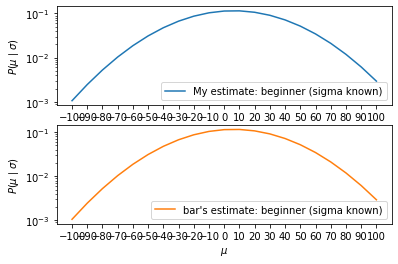

In [7]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, p_p_b,'C0', label="My estimate: beginner (sigma known)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="best")

ax2.semilogy(gridcols, p_bar_b,'C1' ,label="bar's estimate: beginner (sigma known)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax2.legend(loc="best")

plt.show()

For the rest of the pset ill keep the same color coding for simpilicity 
My estimates - blue 
Bar estimate - Orange
Tdistribution(for later)-green

Plot showing the p(mu|sigma distribution for my estimation and the bars estimation) on semilog scale- On the same figure

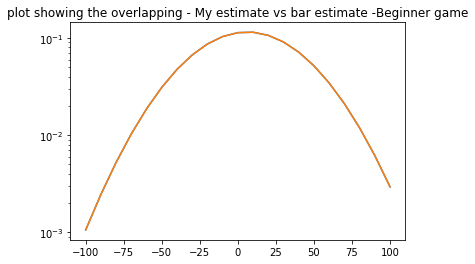

In [8]:
plt.semilogy(gridcols, p_p_b, label="My estimate: beginner (sigma known)")
plt.semilogy(gridcols, p_bar_b, label="bar's estimate: beginner (sigma known)") 
plt.title('plot showing the overlapping - My estimate vs bar estimate -Beginner game')
plt.show()

So far what I can say is that with a fixed sigma the way we generate the proability doenst deliver a different distribution then the distribution obtained by the way they generated the beginner game probability in the bar 

# The advanced game 

for this part the process is very similar then what i described in the part above 
The only difference is that we dont want to keep sigma static- we want to vary sigma (it will take 20 different value)
So instead of having one single array containing 21 probabilities 
I will create a list composed of 20 list each one composed of 21 probabilities 
Again I used a normal distribution to estimate each signle probability 
The only deno minator is the sum of all the value in the numerator table(or matrix- which is the same size then the final probability one) - 
I tried without log because I didnt encounter overflow problems

In [9]:
def test_advanced(X,sigma_values=gridrows, mu_values=gridcols):
    # to initializing matrix 
    proba2 = [ [ 0 for i in range(ncols) ] for j in range(nrows) ] #initialization 
    numerators = [ [ 0 for i in range(ncols) ] for j in range(nrows) ] # initializatiion - same size then proba2
    index_counter=0 
    marginalized_proba=[]
    sum_temp=[]
    for j in sigma_values:
        numerator_temp=[]*21 #reinitialize
        for i in mu_values:
            num=np.prod(stats.norm.pdf(X,loc=i,scale=j))
            numerator_temp.append(num)   
        numerators[index_counter]= numerator_temp
        index_counter= index_counter+1
        #get the denominator
    for k in range(0,len(numerators)):
        sum_temp.append(sum(numerators[k]))
    denominator=sum(sum_temp) 
    
    index_counter=0 #reinitialised 
    for s in range(0,len(sigma_values)):
        proba2[index_counter] = [(nume/denominator) for nume in numerators[s]] #division in log space (so substraction)
        index_counter=index_counter+1
    proba_marg = np.sum(proba2, 0)   #sum over all the values of the matric 
        
  
    return proba2,proba_marg

In [10]:
##test
# num_test,deno_test,proba_test,proba_marg_test=test_advanced(X=X,sigma_values=gridrows, mu_values=gridcols)
# print(sum(proba_marg_test))
# print(proba_marg_test)

In [11]:
def probdist_advanced(X, mu_values=gridcols):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column.
    """
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)     # note that numpy.sd() by default calculates a population std dev; to get sample std. dev., set ddof=1
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= s / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)   # normalization constant
    Pr  = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

In [12]:
p_bar_a = probdist_advanced(X, gridcols)
proba_matrix,marg_proba =test_advanced(X,sigma_values=gridrows, mu_values=gridcols)

In [13]:
#check #expect around 1 
# print(sum(marg_proba))
# print(sum(p_bar_a))

in order to better understand vizualise this proba_matrix I will use a heat mat - 
the highest probability correspond to a value of sigma =10 and mu=10 


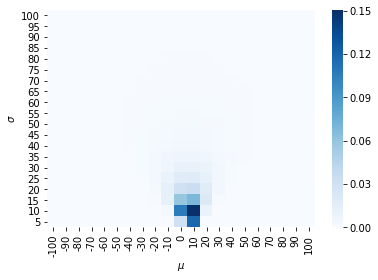

In [14]:
# for seaborn heatmap
probablity_grid=np.asarray(proba_matrix)
sns.heatmap(data=probablity_grid,xticklabels=gridcols.astype(int),\
yticklabels=gridrows.astype(int),cmap="Blues")
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.show()


So this is, given my estimate using those 3 data point the highest chance that I have to win (which is 0.15)-lets soo how this compares to how the bar estimate the probabilities for the advanced game

Using the maginal probaility lets vizualise the distribution we obtained

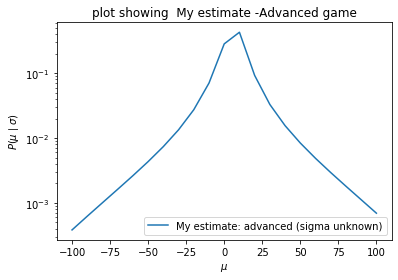

In [15]:
plt.semilogy(gridcols, marg_proba,'C0',label="My estimate: advanced (sigma unknown)")
plt.title('plot showing  My estimate -Advanced game')
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.legend()
plt.show()

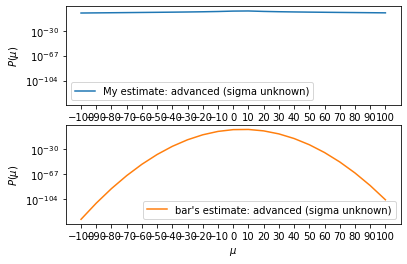

In [16]:
#lets compare with the bar estimate
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col


ax1.semilogy(gridcols, marg_proba, 'C0',label="My estimate: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax1.legend(loc="best")


ax2.semilogy(gridcols, p_bar_a, 'C1',label="bar's estimate: advanced (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")


plt.show()

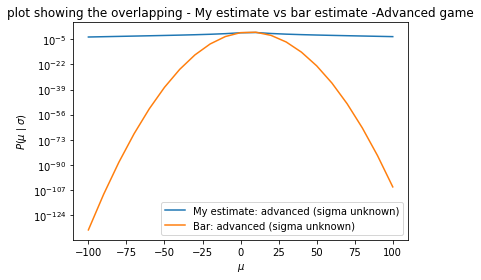

In [17]:
#lets plot the same thing then above just on the same figure
plt.semilogy(gridcols, marg_proba,'C0',label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a ,'C1',label="Bar: advanced (sigma unknown)")
plt.title('plot showing the overlapping - My estimate vs bar estimate -Advanced game')
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.legend()
plt.show()

Overall the probability I predict are greater then the one predictesd by the bar but lets zoom in and see..

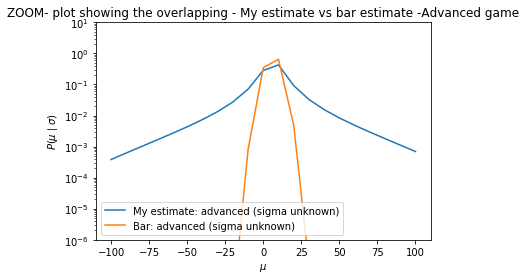

In [18]:

#zoom
plt.semilogy(gridcols, marg_proba, 'C0',label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a , 'C1', label="Bar: advanced (sigma unknown)")
plt.title('ZOOM- plot showing the overlapping - My estimate vs bar estimate -Advanced game')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.ylim(10**-6,10)
plt.show()


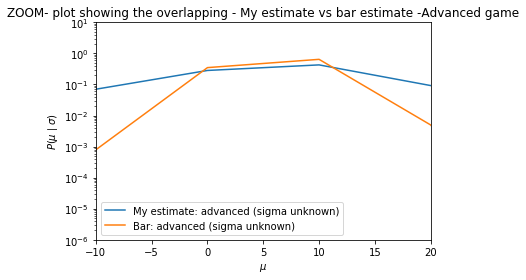

In [19]:
#lets zoom even more 
plt.semilogy(gridcols, marg_proba, 'C0',label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a ,'C1', label="Bar: advanced (sigma unknown)")
plt.title('ZOOM- plot showing the overlapping - My estimate vs bar estimate -Advanced game')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.ylim(10**-6,10)
plt.xlim(-10,20)
plt.show()


Please note that for the next part I wasnt too sure if I shouldnt include it in this part or the next part(Question3) 

Lets now use  a T-distribution and see how this enables us to predict the Probability

In [20]:
def tdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
	according to a Student's t distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    t    = [ stats.ttest_1samp(X, mu)[0] for mu in mu_values ]
    Pr   = [ stats.t.pdf(val, N-1) for val in t ]
    Z    = sum(Pr)
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr



In [21]:
proba_t=tdist_advanced(X=X, mu_values=gridcols) #run the function

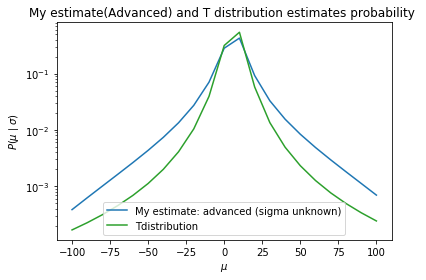

In [22]:
#include T distrbition
plt.semilogy(gridcols, marg_proba,'C0', label="My estimate: advanced (sigma unknown)")
#plt.semilogy(gridcols, p_bar_a , label="Bar: advanced (sigma unknown)")
plt.semilogy(gridcols, proba_t , 'C2',label="Tdistribution ")
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.title('My estimate(Advanced) and T distribution estimates probability ')
plt.show()

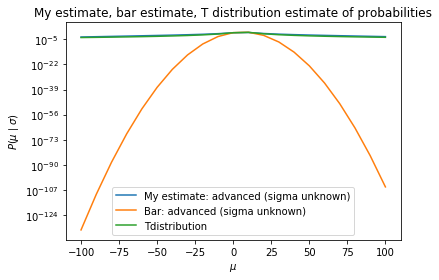

In [23]:
#include T distrbition
plt.semilogy(gridcols, marg_proba,'C0', label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a ,'C1', label="Bar: advanced (sigma unknown)")
plt.semilogy(gridcols, proba_t , 'C2',label="Tdistribution")
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.legend()
plt.title('My estimate, bar estimate, T distribution estimate of probabilities')
plt.show()

# PART 3 

What is important to understand is that when, for a given mu , my estimate of probability is higher(blue curve above the orange curve) that means that the Bar underestimate the probaility of winning and this is a good opportunity to bet. 

basically how can we gain the system = having greater odd that they think we do - this is my understanding of having an advantage
By taking the ratio of my estimate vs bar estimate at each given mu we can actually have a better sense of when the probability are the more underestimated by the bar


In [24]:
#find the ranges where our estimate is higher thn the bar estimate -marg_proba/p_bar_a
#ratio 

good_bet_mu_index=[] #list_index_mu_better_prediction
good_bet_mu=[]
ratio=[]
for i in range(0,21):
    ratio.append(marg_proba[i]/p_bar_a[i])
    if marg_proba[i]>p_bar_a[i]:
        good_bet_mu_index.append(i)
        good_bet_mu.append(gridcols[i])
        

In [25]:
#len(marg_proba)==len(p_bar_a) #test
#len(good_bet_mu) #19 values of mu where our estimate has a higher proba - worth to bet but out of those 19 which one is more 
#gridcols[np.argmax(ratio)] #value of mu where the probability is the more underestimated

the mu where there is an advantage are
-100.0 -90.0 -80.0 -70.0 -60.0 -50.0 -40.0 -30.0 -20.0 -10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0 

mu where the difference is higher is -100.0!


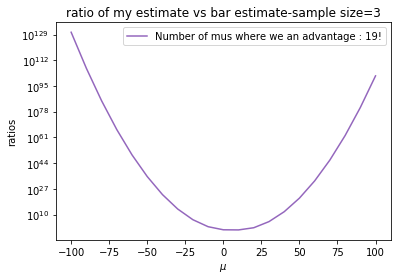

In [26]:
print('the mu where there is an advantage are')
for i in good_bet_mu:
    print(i, end=" ")
    
print('\n')
print('mu where the difference is higher is %s!' %str(gridcols[np.argmax(ratio)]))
plt.semilogy(gridcols,ratio,'C4',label="Number of mus where we an advantage : %s!"  %str(len(good_bet_mu)))
plt.title('ratio of my estimate vs bar estimate-sample size=3')
plt.xlabel('$\mu$')
plt.ylabel('ratios')
plt.legend()
plt.show()


NOW I will GENERATE observation OF DIFFERENT SIZE 
Increasily increasing and see how our estimate (with unkownn sigma differes from bars estimate ))
sample size=10 and sample size=100
What I expect is that as we increase the sample size we will obtain a value of sigma and mu closer to the real mean and the real sigma

In [27]:
np.random.seed(2) #reproductibility purposes
X10  = np.random.normal(loc=true_mu, scale=true_sigma, size=10) #generate points(following a normal distrbution)
X100  = np.random.normal(loc=true_mu, scale=true_sigma, size=100)


In [28]:
#run function 
p_bar_a_10 = probdist_advanced(X10, gridcols)
proba_matrix_10,marg_proba_10 =test_advanced(X10,sigma_values=gridrows, mu_values=gridcols)
proba_t_10=tdist_advanced(X=X10, mu_values=gridcols)
p_bar_a_100 = probdist_advanced(X100, gridcols)
proba_matrix_100,marg_proba_100 =test_advanced(X100,sigma_values=gridrows, mu_values=gridcols)
proba_t_100=tdist_advanced(X=X100, mu_values=gridcols)

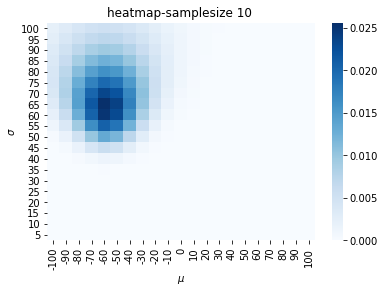

In [29]:
# for seaborn heatmap for sample size 10 
probablity_grid=np.asarray(proba_matrix_10)
sns.heatmap(data=probablity_grid,xticklabels=gridcols.astype(int),\
yticklabels=gridrows.astype(int),cmap="Blues")
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title('heatmap-samplesize 10 ')
plt.show()

harder to compare - lets see 10 points is still a small number but lets see what estimation we can make using those 10 points 


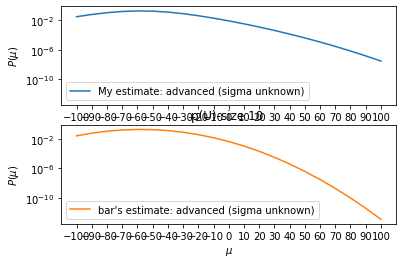

In [30]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col


ax1.semilogy(gridcols, marg_proba_10,'C0', label="My estimate: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax1.legend(loc="best")


ax2.semilogy(gridcols, p_bar_a_10, 'C1',label="bar's estimate: advanced (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.title('p(U)-size 10 ')
plt.show()

Looks like the graph are more similar that what we had for the 3 observations - 
lets plot them on the same graph to compare ( I also ploted the estimates obtained from the T distribution )

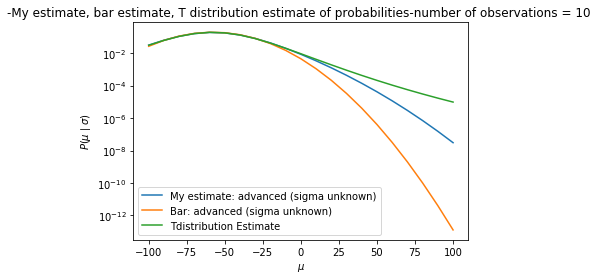

In [31]:
plt.semilogy(gridcols, marg_proba_10, 'C0',label="My estimate: advanced (sigma unknown)") #blue
plt.semilogy(gridcols, p_bar_a_10 ,'C1', label="Bar: advanced (sigma unknown)") #orange
plt.semilogy(gridcols, proba_t_10 ,'C2', label="Tdistribution Estimate") #green
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.legend()
plt.title('-My estimate, bar estimate, T distribution estimate of probabilities-number of observations = 10 ')
plt.show()

What we can see is that overall my  estimatations seem to be more similar to the bar estimatation then what it was for 3 data points observations
But there are still some points where the bar underestimated the probability and this is where we can take advantage

In [32]:
# find the ranges where our estimate is higher thn the bar estimate -marg_proba/p_bar_a
#ratio 

good_bet_mu_index_10=[] #list_index_mu_better_prediction
good_bet_mu_10=[]
ratio_10=[]
for i in range(0,21):
    ratio_10.append(marg_proba_10[i]/p_bar_a_10[i])
    if marg_proba_10[i]>p_bar_a_10[i]:
        good_bet_mu_index_10.append(i)
        good_bet_mu_10.append(gridcols[i])
        

the mu where there is an advantage are
-100.0 -90.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0 

mu where the difference is higher is 100.0!


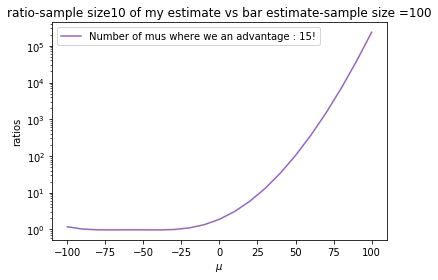

In [33]:
print('the mu where there is an advantage are')
for i in good_bet_mu_10:
    print(i,end=" ")
print('\n')
print('mu where the difference is higher is %s!' %str(gridcols[np.argmax(ratio_10)]))
plt.semilogy(gridcols,ratio_10,'C4',label="Number of mus where we an advantage : %s!"  %str(len(good_bet_mu_10)))
plt.title('ratio-sample size10 of my estimate vs bar estimate-sample size =100')
plt.xlabel('$\mu$')
plt.ylabel('ratios')
plt.legend()
plt.show()

Not only there are less mus where we can take advantage but also the ratio magnitude is a good measure of how 'off' their estimate are and therefore how big is the advantage and as we increase the sample size, both estimatation get better(and therefore closer one to another)- this means that there is less advtange

Now lets redo the same process but this time with a sample size (number of observation)=100 
What I expect to obtain is a value of mu and sigma closer to the real one - More data points allow us to do better predictions

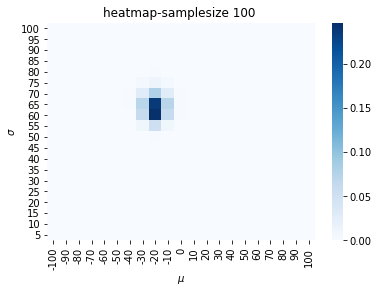

In [34]:
# for seaborn heatmap
probablity_grid=np.asarray(proba_matrix_100)
sns.heatmap(data=probablity_grid,xticklabels=gridcols.astype(int),\
yticklabels=gridrows.astype(int),cmap="Blues")
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title('heatmap-samplesize 100 ')
plt.show()

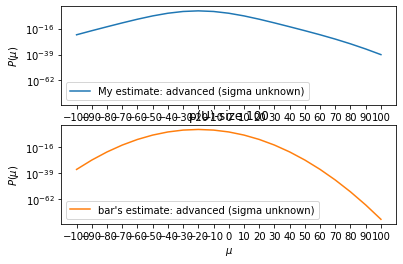

In [35]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col


ax1.semilogy(gridcols, marg_proba_100, 'C0' , label="My estimate: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax1.legend(loc="best")


ax2.semilogy(gridcols, p_bar_a_100,'C1', label="bar's estimate: advanced (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.title('p(U)-size 100')
plt.show()

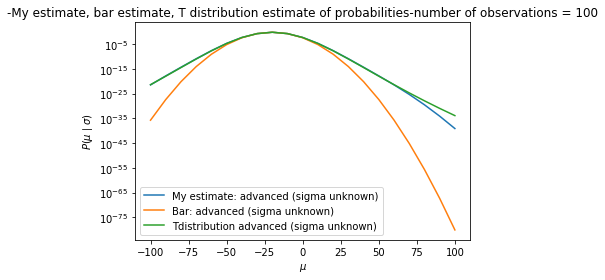

In [36]:
#compare on same plot
plt.semilogy(gridcols, marg_proba_100,'C0', label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a_100 ,'C1', label="Bar: advanced (sigma unknown)")
plt.semilogy(gridcols, proba_t_100 ,'C2', label="Tdistribution advanced (sigma unknown)")
plt.xlabel('$\mu$')
plt.ylabel('$P(\mu \mid \sigma)$')
plt.legend()
plt.title('-My estimate, bar estimate, T distribution estimate of probabilities-number of observations = 100')
plt.show()

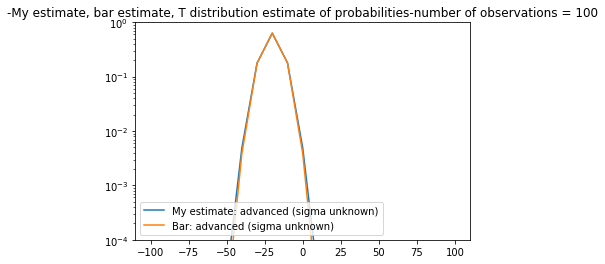

In [37]:
#zoom - close toghter then before - hard to descriminate
plt.semilogy(gridcols, marg_proba_100,'C0', label="My estimate: advanced (sigma unknown)")
plt.semilogy(gridcols, p_bar_a_100 ,'C1', label="Bar: advanced (sigma unknown)")
#plt.semilogy(gridcols, proba_t_100 ,'C2', label="Tdistribution advanced (sigma unknown)")
plt.ylim(0.0001,1)
plt.title('-My estimate, bar estimate, T distribution estimate of probabilities-number of observations = 100')
plt.legend()
plt.show()

In [38]:
# find the ranges where our estimate is higher thn the bar estimate -marg_proba/p_bar_a
#ratio 

good_bet_mu_index_100=[] #list_index_mu_better_prediction
good_bet_mu_100=[]
ratio_100=[]
for i in range(0,21):
    ratio.append(marg_proba_10[i]/p_bar_a_10[i])
    if marg_proba_10[i]>p_bar_a_10[i]:
        good_bet_mu_index_10.append(i)
        good_bet_mu_10.append(gridcols[i])

In [39]:
# find the ranges where our estimate is higher thn the bar estimate -marg_proba/p_bar_a
#ratio 

good_bet_mu_index_100=[] #list_index_mu_better_prediction
good_bet_mu_100=[]
ratio_100=[]
for i in range(0,21):
    ratio_100.append(marg_proba_100[i]/p_bar_a_100[i])
    if marg_proba_100[i]>p_bar_a_100[i]:
        good_bet_mu_index_100.append(i)
        good_bet_mu_100.append(gridcols[i])


the mu where there is an advantage are
-100.0 -90.0 -80.0 -70.0 -60.0 -50.0 -40.0 -30.0 -10.0 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0 

mu where the difference is higher is 100.0!


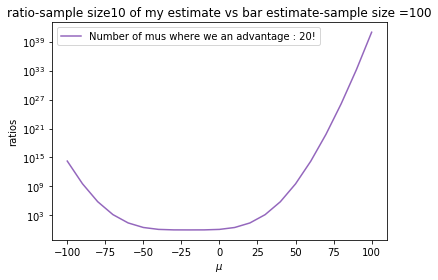

In [40]:
print('the mu where there is an advantage are')
for i in good_bet_mu_100:
    print(i,end=" ")
print('\n')
print('mu where the difference is higher is %s!' %str(gridcols[np.argmax(ratio_100)]))
plt.semilogy(gridcols,ratio_100,'C4',label="Number of mus where we an advantage : %s!"  %str(len(good_bet_mu_100)))
plt.title('ratio-sample size10 of my estimate vs bar estimate-sample size =100')
plt.xlabel('$\mu$')
plt.ylabel('ratios')
plt.legend()
plt.show()

One final note that I want to make is that the reason why T might be a better estimate then the one done by the bar is that the T attributes a higher probability to outliers 
In other terms, when we have a small sample size we might want to favor this distribution over a Z distribution 
